# GenVeg Main Script
## Test dune vegetation implementation
GenVeg is a generalized vegetation growth model that simulates growth due to
photosynthesis as well as processes that control vegetation distribution such
as mortality, senescence, dispersal, and colonization. The model utilizes a 
mixture of existing and new Landlab components to setup the model, simulates
relevant vegetation community dynamics with the local environment, and analyzes
results of the simulation. 

## Main model control set up
### Import components

In [1]:
import numpy as np, pandas as pd
import os, tempfile
from pathlib import Path
from datetime import date
import matplotlib.pyplot as plt
from landlab import RasterModelGrid, imshow_grid, load_params
from landlab.data_record import DataRecord
from landlab.components.genveg import VegParams, GenVeg
from landlab.io.netcdf import write_netcdf, read_netcdf
from scipy.io import netcdf_file
from noaa_coops import Station

### Define time controls

This sets up a one-year run with a daily timestep.

In [2]:
sim_start_date = np.datetime64('2010-01-01')
tot_sim_len_y = 30
veg_time_step_d = 1
env_time_step_d = 1
dt=np.timedelta64(min([veg_time_step_d,env_time_step_d]),'D')
run_length_d=1640

### Define filenames for input files
##### *Note should be located in same folder as this .ipynb

In [3]:
VegInputFile = 'GenVeg_Dune_Simulation.xlsx'

### Read in parameter and data input files
Identify model processes to be included so all required parameters are defined and calculated

In [4]:
inp_file=Path(VegInputFile).absolute()
VegParams(fpath=inp_file,processes=['plantsize','dispersal','mortality'])
vegparams=load_params('veg_params.yml')
print(vegparams)

{'BTS': {'col_params': {'prob_colonization': 0.01, 'time_to_colonization': 365}, 'dispersal_params': {'max_dist_dispersal': 0.4, 'min_size_dispersal': 0.5, 'unit_cost_dispersal': 1.2}, 'duration_params': {'growing_season_end': 305, 'growing_season_start': 144, 'reproduction_start': 180, 'senescence_start': 273}, 'grow_params': {'glucose_requirement': {'leaf': 1.463, 'reproductive': 1.414, 'root': 1.444, 'stem': 1.513, 'storage': 1.415}, 'growth_max_biomass': 13.899999999999999, 'growth_min_biomass': 0.062222222222222213, 'k_light_extinct': 0.48, 'light_half_sat': 100, 'p_max': 0.05, 'plant_part_max': {'leaf': 5.5, 'reproductive': 4, 'root': 4.3, 'stem': 4.1, 'storage': 1}, 'plant_part_min': {'leaf': 0.03, 'reproductive': 0, 'root': 0.01, 'stem': 0.022222222222222223, 'storage': 0.01}, 'respiration_coefficient': {'leaf': 0.03, 'reproductive': 0.01, 'root': 0.015, 'stem': 0.015, 'storage': 0.01}, 'root_to_leaf': {'a': 0.031, 'b1': 0.951, 'b2': 0}, 'root_to_stem': {'a': -0.107, 'b1': 1.09

D:\Python\landlab\landlab\components\genveg\load_veg_params.py:251: RuntimeWarning: overflow encountered in exp
  return 1/(1+a*np.exp(-b*x))


### Set up model grid using landlab RasterModelGrid functions

- Create the model grid
- Initialize live vegetation biomass and plant functional type
- Initialize the air temperature driver across the grid

##### **Note variable names should be consistent with landlab standards

In [5]:
env_fname='data\POWER_Point_Daily_20091231_20151230_039d81N_074d09W_LST.csv'
env_data_file=Path(env_fname).absolute()
env_data=np.genfromtxt(env_fname, dtype={'names': ('year','doy','par_Wm^-2','temp_C','precip_mm','root_sm','wind_sp','wid_dir'),'formats': ('int', 'int', 'f8', 'f8','f8', 'f8', 'f8', 'f8', 'f8')}, delimiter=',', skip_header=16) 

AC=Station(id=8534720)
df_water_levels = AC.get_data(
    begin_date="20100101",
    end_date="20151231",
    product="water_level",
    datum="MSL",
    units="metric",
    time_zone="lst")

df_water_levels.head()



#df_water_levels=pd.read_csv(water_levelfilename)
daily_wl=df_water_levels.resample('D').mean()
daily_wl.to_csv('D:\\Python\\landlab\\notebooks\\GenVeg\\data\\water_level.csv', index=False)

In [6]:

water_levelfilename='D:\\Python\\landlab\\notebooks\\GenVeg\\data\\water_level.csv'
df_water_levels=pd.read_csv(water_levelfilename)
df_water_levels.interpolate(method='linear', inplace=True)
df_WL_MA=df_water_levels.rolling(7)
water_level=df_water_levels['v'].to_numpy()
print(water_level.max())

1.2357375


In [7]:
grid_elev=np.array([0.00233680600000000,	0.252780800000000,	0.447446400000000,	0.719023200000000,	0.918768700000000,	1.21513600000000,	1.43113800000000,	1.68706800000000,	1.88264800000000,	2.09265500000000,	2.25673900000000,	2.47995400000000,	2.70174700000000,	2.98693800000000,	3.58556600000000,
0.0274320000000000,	0.182880000000000,	0.548030400000000,	0.611428800000000,	0.997610400000000,	1.14726700000000,	1.50053000000000,	1.64561500000000,	1.91505800000000,	2.08727000000000,	2.27563700000000,	2.40731000000000,	2.75691600000000,	2.94101500000000,	3.26288400000000,
0.0393192000000000,	0.202387200000000,	0.474573600000000,	0.554431200000000,	1.00888800000000,	1.14940100000000,	1.50418800000000,	1.65536900000000,	1.89799000000000,	2.10555800000000,	2.30642200000000,	2.46430800000000,	2.78922500000000,	2.94894000000000,	3.21320200000000,
0.0457200000000000,	0.152400000000000,	0.520598400000000,	0.609600000000000,	1.02321400000000,	1.21158000000000,	1.47949900000000,	1.65506400000000,	1.98882000000000,	2.19791300000000,	2.39603300000000,	2.55818600000000,	2.81787600000000,	2.87091100000000,	3.13060100000000,
0.0972312000000000,	0.229209600000000,	0.600760800000000,	0.618439200000000,	1.09941400000000,	1.25882400000000,	1.58983700000000,	1.75473400000000,	2.03636900000000,	2.16103200000000,	2.41523500000000,	2.61030700000000,	2.82732500000000,	2.94863500000000,	3.15498500000000,
0.0420624000000000,	0.249326400000000,	0.640384900000000,	0.750112800000000,	1.15427800000000,	1.33289100000000,	1.66603700000000,	1.87055800000000,	2.17352900000000,	2.34269300000000,	2.51277100000000,	2.67736300000000,	2.79227300000000,	2.87121600000000,	3.11200800000000,
0.0795528100000000,	0.259080000000000,	0.652576800000000,	0.733044000000000,	1.19481600000000,	1.41884400000000,	1.72974000000000,	1.90103800000000,	2.15615500000000,	2.39664200000000,	2.60390600000000,	2.68376400000000,	2.79135800000000,	2.88706600000000,	3.04312300000000])

In [8]:
#Create grid 10x10 node grid with 2 m node spacing and xy of origin in lat long roughly corresponding to Island Beach State Park
pg = RasterModelGrid((9, 17), 4, xy_of_reference=(-74.08,39.79))
pg.axis_units = ('m', 'm')

#Create dummy datasets of mean monthly temperature, PAR, distance to the shore, and elevation relative to sea level
meantemp=env_data['temp_C']
NJ_avg_par=env_data['par_Wm2']                

#Initialize with a dummy data sets 
_ = pg.add_field('air__temperature_C', meantemp[0]*np.ones(pg.number_of_cells), at='cell', units='C' )
_ = pg.add_field('radiation__par_tot', NJ_avg_par[0]*np.ones(pg.number_of_cells), at='cell', units='W/m^2')
_ = pg.add_field('elevation__MSL_m', grid_elev, at='cell', units='m_MSL')

_ = pg.add_field('elevation__above_WL', grid_elev-water_level[0], at='cell', units='m')

In [9]:
core_nodes=pg.core_nodes
x=pg.node_axis_coordinates(0)
x=x[core_nodes]
y=pg.node_axis_coordinates(1)
y=y[core_nodes]
z=pg['cell']['elevation__above_WL']
num_rows=np.unique(x)

In [10]:
dist2shore=np.zeros_like(grid_elev)
for row in num_rows:
  row_loc=np.nonzero(x==row)
  row_x=x[row_loc]
  row_y=y[row_loc]
  row_z=z[row_loc]
  inundated=np.nonzero(row_z<0)
  shore_cell_idx=inundated[-1]
  if shore_cell_idx.size <=0:
    m=(row_z[1]-row_z[0])/(row_y[1]-row_y[0])
    b=row_z[0]-m*row_y[0]
    shore_y=(0-b)/m

  else:
      wet_cell=shore_cell_idx[-1]
      dry_cell=wet_cell+1
      shore_z_wet=row_z[wet_cell]
      shore_y_wet=row_y[wet_cell]
      shore_z_dry=row_z[dry_cell]
      shore_y_dry=row_y[dry_cell]
      m=(shore_z_wet-shore_z_dry)/(shore_y_wet-shore_y_dry)
      b=shore_z_wet-m*shore_y_wet
      shore_y=(0-b)/m

  shore_dist=row_y-shore_y
  dist2shore[row_loc]=shore_dist
_ = pg.add_field('Distance to shore', dist2shore, at='cell', units='m', clobber=True)


Now we initialize plants. We can do this in multiple ways. Here we are going to seed two species in a grid with 1/2 occupied by Ammophila, 1/2 by Spartina, at single and double planting densities, respectively.

Future iterations will rely on species boundaries and percent cover to initialize the plants.

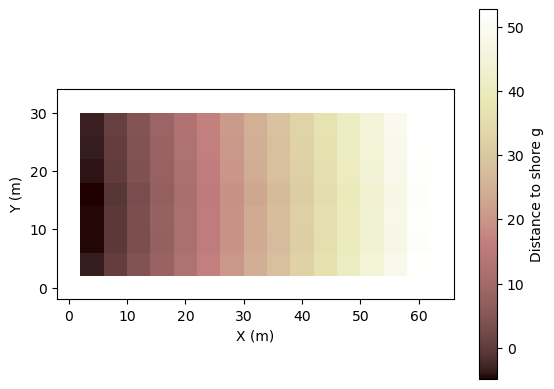

In [11]:
imshow_grid(pg, 'Distance to shore', at='cell', colorbar_label='Distance to shore g')

In [12]:
#Initialize plant functional type as burial tolerant stabilizer or dune builder and randomly place on grid
_ = pg.add_field('vegetation__percent_cover', np.random.default_rng().uniform(low=0.0, high=0.2, size=pg.number_of_cells), at='cell', clobber=True)
plant_list=[['DB','null'],['DB','BTS'],['null','BTS']]
_ = pg.add_field('vegetation__plant_species',np.random.default_rng().choice(plant_list,pg.number_of_cells), at='cell', clobber=True)


In [13]:
pg['cell']['vegetation__percent_cover']

array([  1.40919559e-01,   1.02992390e-01,   1.54156825e-01,
         2.87781970e-02,   8.22165284e-02,   7.65905484e-02,
         1.03662568e-01,   5.43108689e-02,   1.82416235e-01,
         7.26474986e-02,   6.69607648e-02,   1.51950422e-01,
         1.87263172e-01,   1.79988387e-02,   8.84776263e-02,
         1.58120797e-01,   1.27744951e-01,   1.13600353e-01,
         1.98709079e-01,   1.73919925e-01,   1.35018548e-01,
         6.05896130e-02,   4.59025817e-02,   4.55121649e-02,
         1.19597192e-01,   1.66277931e-01,   6.78005671e-02,
         4.05790465e-02,   1.85376333e-01,   1.90695379e-02,
         1.68933673e-01,   1.50517592e-01,   2.72578400e-02,
         1.17983920e-01,   9.21214006e-02,   9.50939962e-02,
         1.22426281e-01,   1.80485904e-01,   1.66183712e-01,
         2.02357542e-02,   4.29651831e-02,   3.40883856e-02,
         2.77223890e-02,   1.85187932e-01,   1.22410681e-01,
         1.95733003e-01,   9.34001909e-02,   1.77986078e-04,
         4.75799459e-02,

pg['cell']['vegetation__plant_species']

### Define model time variables

Initialize dune GenVeg class with veg_params from Excel file

In [14]:
foredune=GenVeg(pg,dt,sim_start_date,vegparams)

In [15]:
print(vegparams)

{'BTS': {'col_params': {'prob_colonization': 0.01, 'time_to_colonization': 365}, 'dispersal_params': {'max_dist_dispersal': 0.4, 'min_size_dispersal': 0.5, 'unit_cost_dispersal': 1.2}, 'duration_params': {'growing_season_end': 305, 'growing_season_start': 144, 'reproduction_start': 180, 'senescence_start': 273}, 'grow_params': {'glucose_requirement': {'leaf': 1.463, 'reproductive': 1.414, 'root': 1.444, 'stem': 1.513, 'storage': 1.415}, 'growth_max_biomass': 13.899999999999999, 'growth_min_biomass': 0.062222222222222213, 'k_light_extinct': 0.48, 'light_half_sat': 100, 'p_max': 0.05, 'plant_part_max': {'leaf': 5.5, 'reproductive': 4, 'root': 4.3, 'stem': 4.1, 'storage': 1}, 'plant_part_min': {'leaf': 0.03, 'reproductive': 0, 'root': 0.01, 'stem': 0.022222222222222223, 'storage': 0.01}, 'respiration_coefficient': {'leaf': 0.03, 'reproductive': 0.01, 'root': 0.015, 'stem': 0.015, 'storage': 0.01}, 'root_to_leaf': {'a': 0.031, 'b1': 0.951, 'b2': 0}, 'root_to_stem': {'a': -0.107, 'b1': 1.09

In [16]:
foredune.get_int_output()

[{'DB': 0.14091955851075838, 'null': 0.0}, {'null': 0.0, 'BTS': 0.10299238976207362}, {'DB': 0.15415682517594487, 'null': 0.0}, {'DB': 0.015663828367002097, 'BTS': 0.013114368681634993}, {'DB': 0.037940892275499377, 'BTS': 0.044275636116490144}, {'DB': 0.040301944593695876, 'BTS': 0.036288603821809123}, {'DB': 0.10366256792601772, 'null': 0.0}, {'DB': 0.054310868945946417, 'null': 0.0}, {'null': 0.0, 'BTS': 0.18241623496059883}, {'null': 0.0, 'BTS': 0.072647498586329975}, {'null': 0.0, 'BTS': 0.06696076484698131}, {'DB': 0.15195042160084404, 'null': 0.0}, {'DB': 0.18726317152990599, 'null': 0.0}, {'null': 0.0, 'BTS': 0.017998838728087319}, {'DB': 0.039492796758566338, 'BTS': 0.048984829517106747}, {'DB': 0.15812079681881908, 'null': 0.0}, {'null': 0.0, 'BTS': 0.12774495130532654}, {'DB': 0.11360035323643901, 'null': 0.0}, {'null': 0.0, 'BTS': 0.1987090786868346}, {'null': 0.0, 'BTS': 0.1739199254243991}, {'DB': 0.064368382812990219, 'BTS': 0.070650165491503311}, {'null': 0.0, 'BTS': 0.

In [17]:
DB=pd.DataFrame(foredune.plant_species[1].species_plants())
BTS=pd.DataFrame(foredune.plant_species[0].species_plants())

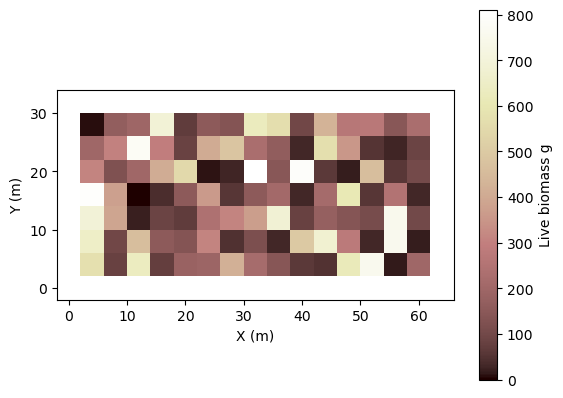

In [18]:
imshow_grid(pg, 'vegetation__total_biomass', at='cell', colorbar_label='Live biomass g')

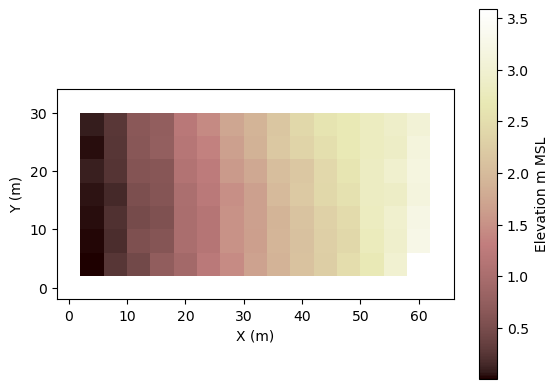

In [19]:
imshow_grid(pg, 'elevation__MSL_m', at='cell',colorbar_label='Elevation m MSL')

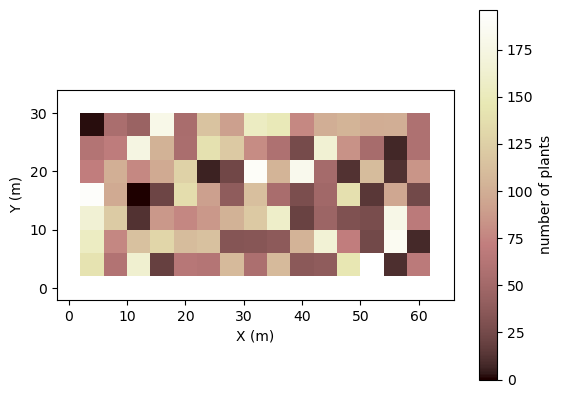

In [20]:
imshow_grid(pg, 'vegetation__n_plants', at='cell', colorbar_label='number of plants')

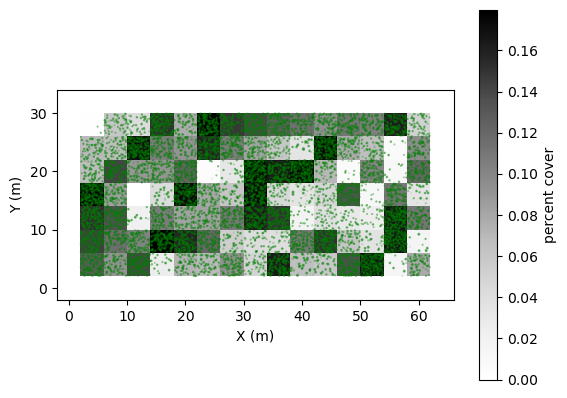

In [21]:
imshow_grid(pg, 'vegetation__percent_cover', at='cell', colorbar_label='percent cover', cmap='Greys')
ax=plt.gca()
end_data=pd.concat([DB,BTS], sort=False)
plant_locs=end_data[['x_loc','y_loc']].to_numpy()
sizes=end_data['root_sys_width'].values/2
for idx,center in enumerate(plant_locs):
    circle = plt.Circle(center, sizes[idx], alpha=0.5, color='green')
    ax.add_patch(circle)
plt.show()


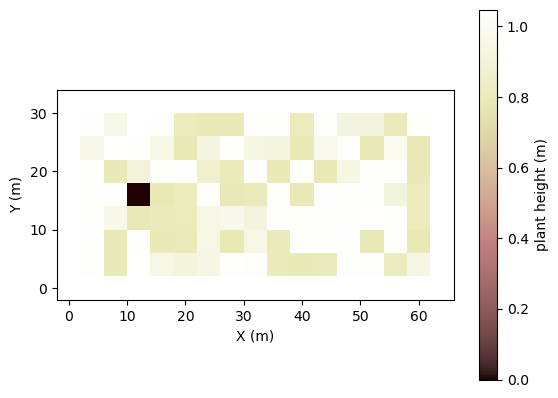

In [22]:
imshow_grid(pg, 'vegetation__plant_height', at='cell', colorbar_label='plant height (m)')

pd.DataFrame(foredune.plant_species[1].species_plants())

## Main model loop script
This is the main model loop that controls the simulation that
- Advances model time 
- Updates environmental variables
- Simulates changes to vegetation communities
- Stores outputs

In [23]:
temp_dir = tempfile.mkdtemp()
os.chdir(temp_dir)
for i in range(run_length_d):
    #update temp attribute on grid
    pg.at_cell['air__temperature_C']= meantemp[i]*np.ones(pg.number_of_cells)
    pg.at_cell['radiation__par_tot']= NJ_avg_par[i]*np.ones(pg.number_of_cells)
    pg.at_cell['elevation__above_WL']=pg.at_cell['elevation__MSL_m']-(water_level[i]*np.ones(pg.number_of_cells))
    z=pg.at_cell['elevation__above_WL']
    dist2shore=np.zeros_like(grid_elev)
    for row in num_rows:
        row_loc=np.nonzero(x==row)
        row_x=x[row_loc]
        row_y=y[row_loc]
        row_z=z[row_loc]
        inundated=np.nonzero(row_z<0)
        shore_cell_idx=inundated[-1]
        if shore_cell_idx.size<=0:
            m=(row_z[1]-row_z[0])/(row_y[1]-row_y[0])
            b=row_z[0]-m*row_y[0]
            shore_y=(0-b)/m

        else:
            wet_cell=shore_cell_idx[-1]
            dry_cell=wet_cell+1
            shore_z_wet=row_z[wet_cell]
            shore_y_wet=row_y[wet_cell]
            shore_z_dry=row_z[dry_cell]
            shore_y_dry=row_y[dry_cell]
            m=(shore_z_wet-shore_z_dry)/(shore_y_wet-shore_y_dry)
            b=shore_z_wet-m*shore_y_wet
            shore_y=(0-b)/m

        shore_dist=row_y-shore_y
        dist2shore[row_loc]=shore_dist
    pg.at_cell['Distance to shore']=dist2shore
    #update solar radiation on grid
    foredune.run_one_step()
    
    if (i/7).is_integer():
        foredune.save_output()
        write_netcdf("dune.nc",pg, format="NETCDF3_64BIT",append=True, time=(foredune.current_day-foredune.start_date).astype(float)-1, names=['vegetation__total_biomass', 'vegetation__n_plants', 'vegetation__percent_cover'])
        #imshow_grid(pg, 'vegetation__total_biomass', at='cell', colorbar_label='Total Biomass (g)')


I emerge from dormancy
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing seas

In [24]:
output=foredune.get_plant_output()

grid = netcdf_file('crop.nc', 'r')
print(grid.__dict__)

timegrid=grid.variables['t']
timegrid[:]

vegbio=grid.variables['vegetation__total_biomass']
vegbio.shape

vegbio[10,:,:]

In [25]:
output.index.unique(level=2)

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            5880, 5881, 5882, 5883, 5884, 5885, 5886, 5887, 5888, 5889],
           dtype='int64', name='item_id', length=5890)

In [26]:
output.loc[0, 'DB',:] #timestep,species,plant number in []

,grid_element,element_id,vegetation__root_biomass,vegetation__leaf_biomass,vegetation__stem_biomass,vegetation__storage_biomass,vegetation__repro_biomass,vegetation__plant_age
item_id,,,,,,,,
0,cell,0.0,4.349236,0.0,0.0,0.126715,4.403817,0.0
1,cell,0.0,1.823432,0.0,0.0,0.293915,9.269267,0.0
2,cell,0.0,2.624027,0.0,0.0,0.273749,5.360079,0.0
3,cell,0.0,0.747237,0.0,0.0,0.707417,4.808575,0.0
4,cell,0.0,3.768531,0.0,0.0,0.934808,7.216810,0.0
...,...,...,...,...,...,...,...,...
5885,cell,104.0,6.878908,0.0,0.0,0.438126,4.407447,0.0
5886,cell,104.0,1.252025,0.0,0.0,0.575675,4.434095,0.0
5887,cell,104.0,2.225193,0.0,0.0,0.554511,1.991119,0.0


output.loc[21.0]

In [27]:
pd.set_option('display.max_rows',None)
DB=pd.DataFrame(foredune.plant_species[1].species_plants())
BTS=pd.DataFrame(foredune.plant_species[0].species_plants())

In [28]:
biomass = output["vegetation__root_biomass"].values
display(biomass)


array([ 2.97255487,  2.19926972,  0.19505315, ...,  6.34587139,
        6.34657854,  6.3476466 ])

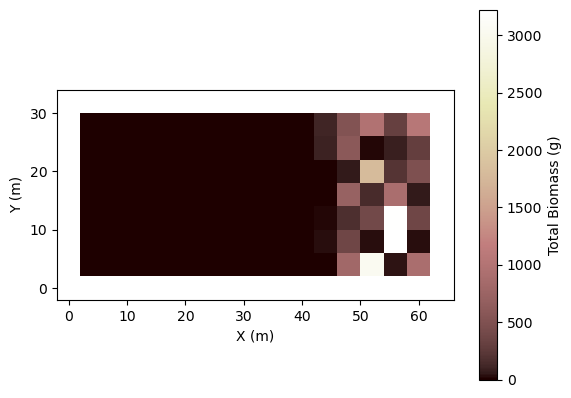

In [29]:
imshow_grid(pg, 'vegetation__total_biomass', at='cell', colorbar_label='Total Biomass (g)')

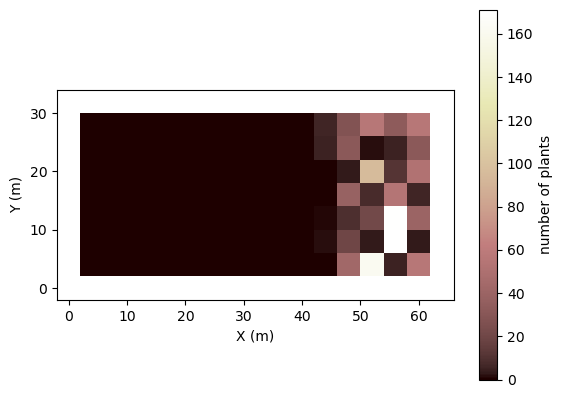

In [30]:
imshow_grid(pg, 'vegetation__n_plants', at='cell', colorbar_label='number of plants')

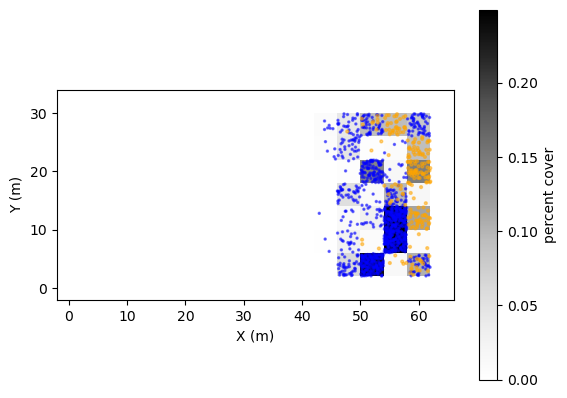

In [31]:
imshow_grid(pg, 'vegetation__percent_cover', at='cell', colorbar_label='percent cover', cmap='Greys')
ax=plt.gca()
end_data=pd.concat([DB,BTS], sort=False)
plant_locs=DB[['x_loc','y_loc']].to_numpy()
sizes=DB['shoot_sys_width'].values
   
for idx,center in enumerate(plant_locs):
    circle = plt.Circle(center, sizes[idx], alpha=0.5, color='blue')
    ax.add_patch(circle)
plant_locs=BTS[['x_loc','y_loc']].to_numpy()
sizes=BTS['shoot_sys_width'].values
for idx,center in enumerate(plant_locs):
    circle = plt.Circle(center, sizes[idx], alpha=0.5, color='orange')
    ax.add_patch(circle)
plt.show()

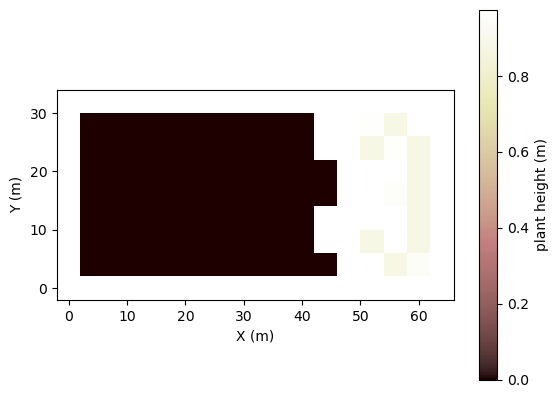

In [32]:
imshow_grid(pg, 'vegetation__plant_height', at='cell', colorbar_label='plant height (m)')

grid.close()